**Problem: Release of multiple aggregate statistics.**

Consider the two following summation queries.

In [1]:
adult['Age'].sum()

NameError: name 'adult' is not defined

In [ ]:
adult[adult['Name'] != 'Anna Brown']['Age'].sum()

In [ ]:
adult['Age'].sum() - adult[adult['Name'] != 'Anna Brown']['Age'].sum()

The same problem arise if we ask *How many people in the database have salary in the range 100k to 200k?*

### What have we learned?

- The security of aggregate data depends on previously released information.
- Releasing useful data makes ensuring privacy very difficult.
- Distinguishing between malicious and non-malicious queries is not possible.


## Differential Privacy

### Differential Privacy

 - It is a mathematical definition
 - Property of an algorithm (a query)
 - A dataset is differentially private if the algorithm that produced it satisfies differential privacy.

### Informal definition

An algorithm is differentially private if, by looking at the output, one cannot tell whether any individual's data was included in the original dataset or not.

The analyst knows no more about any individual in the data after the analysis is completed than she knew before the analysis was begun.

### Neighboring dataset

Let $d(D, D')$ denote the distance of $D$ and $D'$ that is the number of rows that $D$ and $D'$ differ. If, $d(D,D') \le 1$, then  $D$ and $D'$ are neighboring datasets.

Two dataset are neighboring if they differ in  the data of a single individual. E.g. if we remove or change the data of an individual, the result is a dataset that is neighboring to the original.

Distance is sometimes defined by the difference in attributes/columns. Two datasets are neighboring if they differ in one attribute of a single individual. 

If there is only one attribute, the two definitions are the same.

### Definition

 > A randomized algorithm $M$ is $\varepsilon$-differentially private if for all neighboring dataset $D$ and $D'$ and all possible sets of output $S$, $$\frac{\Pr[M(D) \in S]}{\Pr[M(D') \in S]} \le e^\varepsilon $$
 
 The algorithm produces a different output for neighboring datasets with only a small probability.
 

### The parameter $\varepsilon$

 - $\varepsilon$ is the privacy parameter/privacy budget. It tunes the amount of privacy the definition provides.
      - Small $\varepsilon \Rightarrow$ more privacy.
      - Large $\varepsilon \Rightarrow$ less privacy.

### Discrete Distributions

> Suppose the range (output) of $M$ is a discrete (finite) set (e.g., integers, 32-bit floating-point numbers, marital status, etc.), In that case, the definition can consider $S$ to be a single value (e.g., 37, married, etc.). Then we can write $M(D) = S$ instead of $M(D) \in S$ the inequality:
$$ \frac{\Pr[M(D) = S]}{\Pr[M(D') = S]} \le e^\varepsilon $$

### How do we acheive differential privacy?

 - Add noise to the outcome of the algorithm.
 - Randomize response - lie about the answer with some probability

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
adult = pd.read_csv("data.csv")
adult.head(6)

,Name,First Name,Last Name,Sex,SSN,DOB,Birthday,Age,Zip,Education,Marital Status,Occupation,Salary
0,Jason Ortiz,Jason,Ortiz,Male,239-62-5065,12/24/65,12/24,58,55813,Bachelors degree,Widowed,Engineer/ production,Under 25k
1,Anna Brown,Anna,Brown,Female,860-48-3325,03/21/99,03/21,25,25593,Bachelors degree,Never married,Systems developer,100k to 200k
2,Kevin Anderson,Kevin,Anderson,Male,176-24-2913,05/11/67,05/11,57,29066,No degree,Never married,Equities trader,50k to 100k
3,Patricia Clarke,Patricia,Clarke,Female,384-30-3488,12/23/76,12/23,47,81645,High school/GED,Divorce,Restaurant manager,50k to 100k
4,Robert Watson,Robert,Watson,Male,066-16-3817,04/08/01,04/08,23,27301,No degree,Married,Facilities manager,25k to 50k
5,Joseph Carrillo,Joseph,Carrillo,Male,426-75-3893,12/23/88,12/23,35,60983,Masters degree,Never married,Designer/ multimedia,100k to 200k


## Laplace mechanism

### Laplace distribution

Properties:
 - *double exponential* distribution
 - Laplace distribution has two parameters
 - $\mu$: mean (or location), $b > 0$: scale (or diversity)
 - If $\mu=0$ and $b=1$, the positive half-line is exactly an exponential distribution scaled by 1/2.
 
$Lap(t)$ denotes sampling from the Laplace distribution with *location/mean = 0* and *scale t*.

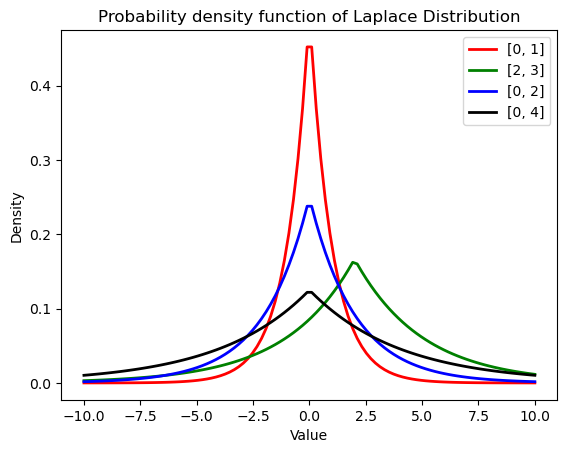

In [4]:
# Step 1: Parameters: loc is the location parameter (mean), scale is the scale parameter (variance)
mean = [0, 2, 0, 0]    # mean (location)
scale = [1, 3, 2, 4]   # scale (diversity)
color = ['r', 'g', 'b', 'k']

# Step 2: Plot the Laplace distribution
x = np.linspace(-10, 10, 100)
for i in range(4):
    pdf = (1/(2*scale[i])) * np.exp(-np.abs(x-mean[i])/scale[i])
    plt.plot(x, pdf, color[i], label = [mean[i], scale[i]], linewidth=2)

plt.title('Probability density function of Laplace Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

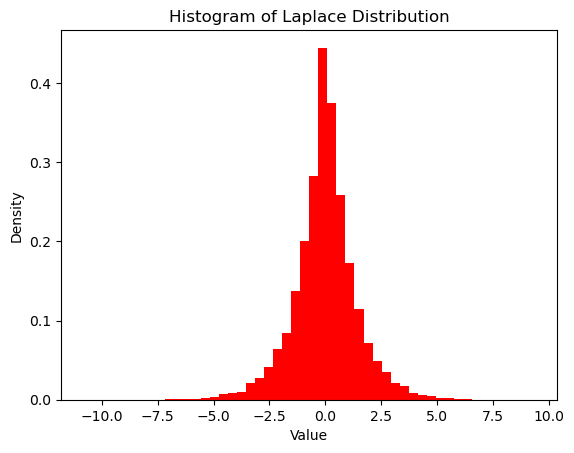

In [5]:
# Step 1: Generate random samples from a Laplace distribution
# Parameters: loc is the location parameter (mean), scale is the scale parameter (variance)
mean = 0    # mean (location)
scale = 1   # scale (diversity)

# Generate 10000 random samples from the Laplace distribution
data = np.random.laplace(loc=mean, scale=scale, size=10000)

# Step 2: Plot the histogram
plt.hist(data, bins=50, density=True, color='r')

plt.title('Histogram of Laplace Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

### Sensitivity

 - The amount of the function's output can change if the input changes.
 - Let $f: \mathcal{D} \rightarrow \mathbb{R}$ be a function. Then $$S(f) = \max_{x,x':d(x),d(x')\le 1} |f(x) - f(x')|$$
 - If $f$ is a count query, then $S(f) = 1$.
 - If $f$ is the age sum query, then $S(f)$ is the maximal possible age of an individual.
 - It is often challenging to compute the sensitivity. We will discuss this later.

### Laplace mechanism

Let $f$ be a function that returns a number. Defy $M$ the following way: $$ M(x) = f(x) + Lap\left(\frac{S(f)}{\varepsilon}\right).$$

If $f$ is a count query, then $$ M(x) = f(x) + Lap\left(\frac{1}{\varepsilon}\right).$$

> **Theorem:** The Laplace mechanism preserves $\varepsilon$-differential privacy.

### Example

We want to know the number of individuals with age at least 40.

In [6]:
adult[adult['Age'] >= 40].shape[0]

10650

In [7]:
sensitivity = 1
epsilon = 0.1

adult[adult['Age'] >= 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

10654.799304969278

### Example 2

We test Laplace-mechanism for a query that would result in 1.

In [8]:
jasons_row = adult[adult['Name'] == 'Jason Ortiz']
jasons_row[jasons_row['Salary'] == 'Under 25k'].shape[0]

1

In [9]:
sensitivity = 1
epsilon = 0.1

jasons_row = adult[adult['Name'] == 'Jason Ortiz']
jasons_row[jasons_row['Salary'] == 'Under 25k'].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

-3.5976359250683165

Let's experiment with different values of $\varepsilon$!

In [10]:
epsilon = 0.1
jasons_row[jasons_row['Salary'] == 'Under 25k'].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

3.4016258589859714

In [11]:
epsilon = 1
jasons_row[jasons_row['Salary'] == 'Under 25k'].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

1.0789349143432905

In [12]:
epsilon = 10
jasons_row[jasons_row['Salary'] == 'Under 25k'].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

1.1476629578127424

In [13]:
epsilon = 100
jasons_row[jasons_row['Salary'] == 'Under 25k'].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

0.9936411810799163

Summary:
 - Differential privacy can protect individuals in a dataset.   
 - Laplace mechanism can provide DP.
 - The level of privacy depends on the parameter $\varepsilon$.
 - Small values of $\varepsilon$ provide more privacy but have less accuracy.
 - Large values of $\varepsilon$ provide less privacy but are more accurate.

## Compositions of DP

### Sequential Composition

We saw that releasing multiple queries of the same data violates privacy for aggregations. Does DP provide privacy?

> Theorem (Sequential Composition):
>    - $M_1$ and $M_2$ are two mechanisms.
>    - If $M_1$ satisfies $\varepsilon_1$-differential privacy, and $M_2$ satisfies $\varepsilon_2$-differential privacy, then the mechanism $M = (M_1,M_2)$ which releases both results, satisfies $\varepsilon_1 + \varepsilon_2$-differential privacy.

 - We can ask for queries from the same dataset multiple times. The result is still DP but with a larger $\varepsilon$ (less private).
 - The given privacy budget is upper bound so that the actual privacy cost may be smaller.

Let's try the differencing attack! With the choice $\varepsilon = 0.5$, the final result satisfies 1-DP. 

In [ ]:
epsilon = 0.5
numb1 = adult[adult['Salary'] == 'Under 25'].shape[0] + np.random.laplace(loc=0, scale=1/epsilon)
adult_no_jason = adult[adult['Name'] != 'Jason Ortiz']
numb2 = adult_no_jason[adult_no_jason['Salary'] == 'Under 25'].shape[0] + np.random.laplace(loc=0, scale=1/epsilon)
numb1 - numb2

Let's compare the privacy cost of the noises that we add to the query. 

In [14]:
epsilon1 = 1
epsilon2 = 1
epsilon_total = 2

# satisfies 1-differential privacy
def F1():
    return np.random.laplace(loc=0, scale=1/epsilon1)

# satisfies 1-differential privacy
def F2():
    return np.random.laplace(loc=0, scale=1/epsilon2)

# satisfies 2-differential privacy
def F3():
    return np.random.laplace(loc=0, scale=1/epsilon_total)

# satisfies 2-differential privacy, by sequential composition
def F_combined():
    return (F1() + F2()) / 2

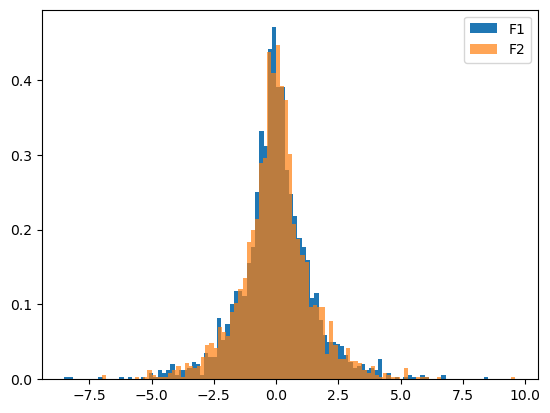

In [15]:
# plot F1
plt.hist([F1() for i in range(2000)], bins=100, label='F1', density = True);

# plot F2 (should look the same)
plt.hist([F2() for i in range(2000)], bins=100, alpha=.7, label='F2', density = True);
plt.legend();

The graph F1 and F2 looks pretty similar, because they are generated by the same distribution.

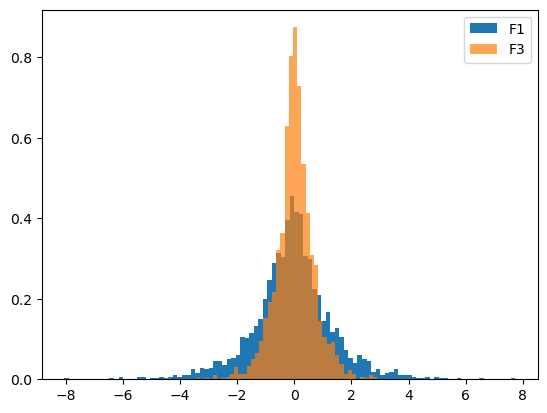

In [16]:
# plot F1
plt.hist([F1() for i in range(2000)], bins=100, label='F1', density = True);

# plot F3 (should look "pointier")
plt.hist([F3() for i in range(2000)], bins=50, alpha=.7, label='F3', density = True);
plt.legend();

The graph **F3** looks *pointier*. It is not a surprise, as the scale is smaller. Therefore **F3** provide less privacy than **F1**, which is exactly what we were expecting from a higher value of $\varepsilon$. 

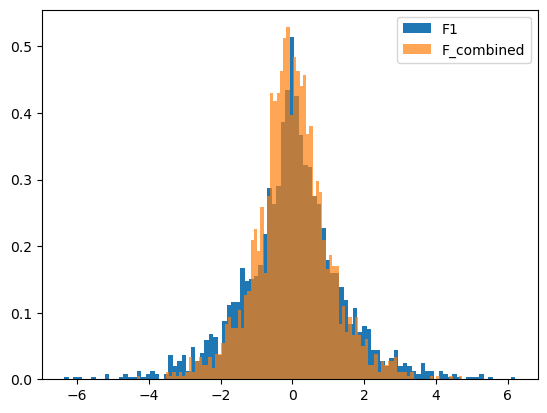

In [17]:
# plot F1
plt.hist([F1() for i in range(2000)], bins=100, label='F1', density = True);

# plot F_combined (should look "pointier")
plt.hist([F_combined() for i in range(2000)], bins=100, alpha=.7, label='F_combined', density = True);
plt.legend();


The graph **F_combined** is a little bit *pointier*, therefore it provide less privacy than **F_1**. This is coincide with our expectation.

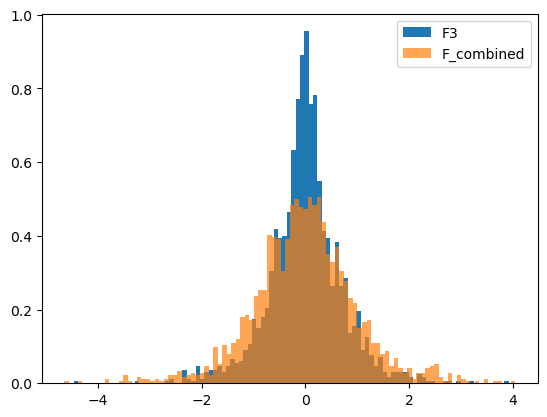

In [18]:
# plot F1
plt.hist([F3() for i in range(2000)], bins=100, label='F3', density = True);

# plot F_combined (should look "pointier")
plt.hist([F_combined() for i in range(2000)], bins=100, alpha=.7, label='F_combined', density = True);
plt.legend();

The graph **F3** is *pointier*, therefore it provides less privacy. The privacy budget for both **F3** and **F_combined** is 2, so why is there a difference? The reason that the 2 is an upper bound for the privacy cost for **F_combined**, the actual cumulative impact on privacy is lower.  

## Parallel Composition

 - Splitting the dataset into disjoint chunks
 - Running a differentially private mechanism on each chunk separately.

 - The chunks are disjoint, so each individual's data appears in exactly one chunk.
 - The mechanism runs exactly once on the data of each individual.
  
> ### Theorem (Parallel Composition) 
> Suppose that $M$ satisfies $\varepsilon$-differential privacy. Split datast $D$ into disjoint chunks, such that $D =D_1 \cup \dots D_k$. Then the mechanism which releases $M(D_1),\dots,M(D_k)$ satisfies $\varepsilon$-differential privacy.
 
  - The budget of running $k$ $\varepsilon$-DP algortihm on disjoint chunks of dataset gives a privacy budget $\varepsilon$ instead of $k\varepsilon$.

### Histograms

Anaysis of a dataset which splits the dataset into "bins" based on value of one of the data attributes, and counts the number of rows in each bin.

Example: Count the number of people in the dataset who achieved a particular educational level.

In [20]:
adult = pd.read_csv("data.csv")
adult['Education'].value_counts().to_frame().head(5)

,count
Education,
High school/GED,5793
Bachelors degree,4337
Some college,3251
Associate degree,2058
No degree,2010


 - Histograms automatically satisfy parallel composition.
 - Each "bin" in a histogram is defined by a possible value for a data attribute (e.g., 'Education' = 'Bachelor's degree')

In [21]:
epsilon = 1

# This analysis has a total privacy cost of epsilon = 1, even though we release many results!
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
s = adult['Education'].value_counts().apply(f)
s.to_frame().head(5)

,count
Education,
High school/GED,5795.835712
Bachelors degree,4334.920036
Some college,3248.619895
Associate degree,2057.011035
No degree,2012.458312


### Contingency Tables (Cross tabulation)

 - Like a multi-dimensional histogram.
 - It counts the frequency of rows in the dataset with particular values for more than one attribute at a time.
 - Contingency tables are frequently used to show the relationship between two variables when analyzing data.
 - E.g., we might want to see counts based on both education level and gender

In [22]:
pd.crosstab(adult['Education'], adult['Sex']).head(5)

Sex,Female,Male
Education,,
Associate degree,996,1062
Bachelors degree,2179,2158
Doctorate,185,196
High school/GED,2960,2833
Masters degree,954,961


 - Each individual participates in eaxctly one count.
 - It is safe to use parallel composition.

In [24]:
ct = pd.crosstab(adult['Education'], adult['Sex'])
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
ct.map(f).head(5)

Sex,Female,Male
Education,,
Associate degree,995.100790,1062.840504
Bachelors degree,2180.157617,2156.874143
Doctorate,185.053361,196.438943
High school/GED,2959.255182,2834.147062
Masters degree,953.960565,960.505996


## Post-processing

 - Informally: It is impossible to reverse the privacy protection provided by DP by post-processing the data in some way.
 
 > ### Post processing
 > If $M$ satisfies DP, then for any function $g$, $g(M)$ satisfies $\varepsilon$-DP.

 - It is safe to perform post-processing that might reduce the noise or improve the signal in the mechanism's output.
  - Once we put DP on a data, it always remains on it.

 - DP provide resistance against privacy attacks based on auxiliary information.
  - E.g., function $g$ might contain auxiliary inforamtion.
  - Linkage attacks based on this information are limited in its effectivenss by the parameter $\varepsilon$.

### Summary

 - Sequential composition bounds the total privacy cost of multiple release of the data when apply DP
 - Parallel composition is based on splitting the dataset into disjoint chunks and run the DP mechanism separately. The privacy cost is only the cost of one DP mechanism.
 - Post-processing property means that it is safe to perform arbitrary computations on the output of DP, in particular it is protect against attacks based on auxiliary inforamtion.

# Approximate Differential Privacy

> Algorithm $M$ is $(\varepsilon,\delta)$-differentially private if the following holds: $$\Pr[M(D) = S] \le e^\varepsilon \Pr[M(D') = S] + \delta$$

The difference between $\epsilon$-DP is the term $\delta$. What is the meaning of $\delta$? 

Informally it guarantee $\varepsilon$-DP with probability $1 -\delta$ and with $\delta$ probability there is no quarantee on privacy.

 - With probability $1 - \delta$, $\frac{\Pr[M(D)=S]}{\Pr[M(D')=S]} \le e^\varepsilon$
 - With probability $\delta$, there is no quarantee at all.

No guarantee? What could happen?

 - With $\delta$ probability, the algorithm can release the entire dataset with all the sensitive information. Therefore $\delta$ should be small, e.g., $\frac{1}{n^2}$, where $n$ is the size of the dataset.
 - In practice, however, it doesn't seems to release a lot of sensitive information.

### Sequential Composition

>If $M_1,M_2$ satisfies $(\varepsilon_1,\delta_1)$-, and $(\varepsilon_2,\delta_2)$-DP, then the mechanism $M = (M_1,M_2)$, which release both results satisfies $(\varepsilon_1 + \varepsilon_2,\delta_1 + \delta_2)$-DP.

Approximate DP also satisfies post-processing and parallel composition.

## Gaussian Mechanism

 - The Gaussian mechanism is an alternative to the Laplave mechanism.
 - Adds Gaussian noise instead of Laplacian noise.
 - It does not satisfy $\varepsilon$-DP (pure DP).
 - It satisfies $(\varepsilon,\delta)$-DP.

 > Let $f$ be a function which returns a number. Mechanism $M$ satisfies $(\varepsilon,\delta)$-DP, if $$M(D) = f(D) + \mathcal{N}(\sigma^2)$$ 
 > where $\sigma^2 = \frac{2s^2\log(1.25/\delta)}{\varepsilon^2}$, $s$ is the sensitivity of $f$ and $\mathcal{N}$ denotes sampling from Gaussian (normal) distribution with center 0 and variance $\sigma^2$.

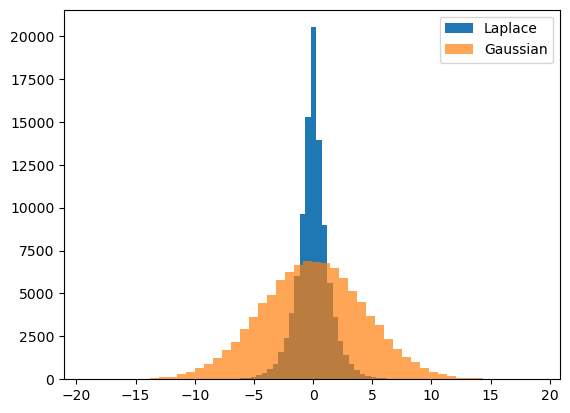

In [25]:
epsilon = 1
vals_laplace = [np.random.laplace(loc=0, scale=1/epsilon) for x in range(100000)]

delta = 10e-5
sigma = np.sqrt(2 * np.log(1.25 / delta)) * 1 / epsilon
vals_gauss = [np.random.normal(loc=0, scale=sigma) for x in range(100000)]
 
plt.hist(vals_laplace, bins=50, label='Laplace')
plt.hist(vals_gauss, bins=50, alpha=.7, label='Gaussian');
plt.legend();

### Comparison of precision

 - Laplace mechanism looks much more pointy, while Gaussian mechanism looks "squished". 
 - This results in a smaller amount of noise in Laplace mechanism. 
 - Laplace mechanism is more accurate.

|-               | Laplace mechanism | Gaussian mechanism |
|----------------|-------------------|--------------------|
|Fail            | No fail           | Fail with $\delta$ prob.|
|Accuracy        | More accurate     | Less accurate      |